# CMIST Hiring Exercise - ML+CV Engineer

The training data is downloaded and extracted the data from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data,

## Aim of the Project: 

Create a model which can be used to recognize and annotate cats in photos. Any training set available online can be used to train the model. Two scripts to be submitted: one to train the model and one which applies the model onto our test set of images (test_set.zip) and draws bounding boxes around cats on the test set as such:

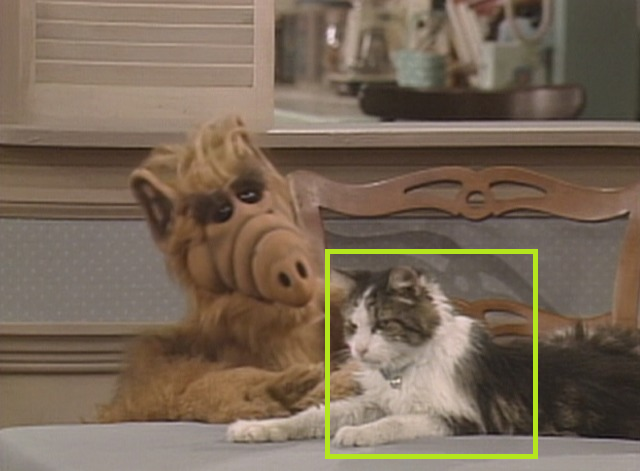

### Package Requirements:
numpy (pip install numpy) tqdm (pip install tqdm)
CPU version of TensorFlow, just do pip install tensorflow To install the GPU version of TensorFlow, you need to get all the dependencies and such.

In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion

TRAIN_DIR = 'D:/train'
TEST_DIR = 'D:/test_set'
FILE_DIR = 'D:/files'
IMG_SIZE = 50
LR = 1e-3

CHECK_POINT_NAME ='model.tfl.ckpt'
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
#train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy')

In [6]:
import tensorflow as tf
tf.reset_default_graph()

In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet1 = conv_2d(convnet, 64, 5, activation='relu')
convnet2 = max_pool_2d(convnet1, 5)

convnet = conv_2d(convnet2, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


Scipy not supported!


In [8]:

if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=2, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)


Training Step: 9403  | total loss: 0.15890 | time: 67.368s
| Adam | epoch: 002 | loss: 0.15890 - acc: 0.9405 -- iter: 24448/24500
Training Step: 9404  | total loss: 0.15365 | time: 68.546s
| Adam | epoch: 002 | loss: 0.15365 - acc: 0.9433 | val_loss: 0.29585 - val_acc: 0.8800 -- iter: 24500/24500
--


In [9]:
model.save(MODEL_NAME)


INFO:tensorflow:C:\Python 3.5\Scripts\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [10]:

print("layer weights:")
w=model.get_weights(convnet.W)
b=model.get_weights(convnet1.b)

layer weights:


100%|████████████████████████████████████████| 110/110 [00:07<00:00, 15.42it/s]


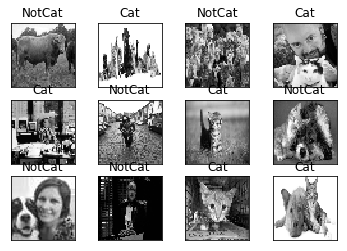

In [11]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]  
    
    if np.argmax(model_out) == 1: str_label='NotCat'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [12]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|███████████████████████████████████████| 110/110 [00:00<00:00, 398.53it/s]


In [15]:
model.load(MODEL_NAME)
w=model.get_weights(convnet.W)

INFO:tensorflow:Restoring parameters from C:\Python 3.5\Scripts\dogsvscats-0.001-2conv-basic.model


In [16]:
import random
import numpy as np

WINDOW_SIZES = [i for i in range(20, 160, 20)]


def get_best_bounding_box(img, predict_fn, step=10, window_sizes=WINDOW_SIZES):
    best_box = None
    best_box_prob = -np.inf

    # loop window sizes: 20x20, 30x30, 40x40...160x160
    for win_size in window_sizes:
        for top in range(0, img.shape[0] - win_size + 1, step):
            for left in range(0, img.shape[1] - win_size + 1, step):
                # compute the (top, left, bottom, right) of the bounding box
                box = (top, left, top + win_size, left + win_size)

                # crop the original image
                cropped_img = img[box[0]:box[2], box[1]:box[3]]

                # predict how likely this cropped image is dog and if higher
                # than best save it
                print('predicting for box %r' % (box, ))
                box_prob = predict_fn(cropped_img)
                if box_prob > best_box_prob:
                    best_box = box
                    best_box_prob = box_prob

    return best_box


    def predict_function(img):
        img_num = img[1]
        img_data = img[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        return model_out
    
    



In [17]:
import scipy 
from keras.preprocessing.image import ImageDataGenerator

img = load_img('test1.jpg')

ImportError: cannot import name 'NUMPY_MKL'